# Figures (final)

In [1]:
%matplotlib inline
import sys 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

alt_data_names = {"LWPL":"GATB","LUMAB":"LMAB", "HERLUMA":"HRLA","HERLUMB":"HRLB", "BASHER":"BSHR","BASLUMA":"BSLA", "BASLUMB":"BSLB"}

In [2]:
combined_all = pd.read_csv("../data/multi/combined_all.csv", index_col=0)
combined_all["Out"].fillna("None", inplace=True)
combined_all.head()

,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_method,median_mcc,median_mcc0,...,median_prec0,median_prec0_method,median_prec_method,median_rec,median_rec_method,median_rep,median_rep_method,id,lfc_mode,isSynthetic
0,BRCA,3,None,DESeq2 Wald,0.05,0,2294.5,2294.5,0.165280,0.165280,...,0.955180,0.970185,0.970185,0.151784,0.145621,0.269616,0.269616,0,post_hoc,False
1,BRCA,3,None,DESeq2 Wald,0.05,1,2161.0,2161.0,0.497009,0.497009,...,0.753902,0.765557,0.765557,0.449721,0.435682,0.270566,0.270566,0,post_hoc,False
2,BRCA,3,None,edgeR LRT,0.05,0,1493.5,1493.5,0.142766,0.142766,...,0.966497,0.971890,0.971890,0.104152,0.100655,0.200720,0.200720,0,post_hoc,False
3,BRCA,3,None,edgeR LRT,0.05,1,1493.5,1493.5,0.437583,0.437583,...,0.810135,0.821953,0.821953,0.316061,0.308851,0.200959,0.200959,0,post_hoc,False
4,BRCA,3,None,edgeR QLF,0.05,0,0.0,0.0,0.062313,0.000000,...,0.000000,0.000000,0.989879,0.000000,0.000000,0.000000,0.000000,0,post_hoc,False


In [3]:
combined_gsea = pd.read_csv(f"../data/multi/combined_gsea_td.rev3.csv", index_col=0)
combined_gsea["Out"].fillna("None", inplace=True)
combined_gsea["Data"].replace(alt_data_names, inplace=True)
combined_gsea.head()

,Data,N,Out,DEA,Enrichment,Library,Ranking,FDR,median_mcc,median_mcc0,median_prec,median_prec0,median_rec,median_rep,median_terms,id
0,BSHR,3,None,DESeq2,gseapy,GO_Biological_Process_2023,logFC,0.05,0.086656,0.081561,0.058333,0.057143,0.105263,0.022347,31.0,0
1,BSHR,3,None,DESeq2,gseapy,KEGG_2021_Human,logFC,0.05,0.118330,0.116316,0.100000,0.100000,0.222222,0.052632,17.5,0
2,BSHR,5,None,DESeq2,gseapy,GO_Biological_Process_2023,logFC,0.05,0.160657,0.160508,0.116026,0.113248,0.210526,0.031915,31.0,1
3,BSHR,5,None,DESeq2,gseapy,KEGG_2021_Human,logFC,0.05,0.192623,0.190189,0.157895,0.153947,0.333333,0.076923,18.5,1
4,BSHR,7,None,DESeq2,gseapy,GO_Biological_Process_2023,logFC,0.05,0.194591,0.191232,0.157895,0.157072,0.210526,0.040816,20.0,2


In [4]:
dea = "DESeq2 Wald"
logFC = 1
lfc_mode = "formal"
fdr = 0.05

c = combined_all[~combined_all["isSynthetic"]]
c = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr) & (c["lfc_mode"] == lfc_mode) & (c["DEA"]==dea)]
order_rep = c[c["N"]==15].sort_values(by="median_rep_method")["Data"].values
print(order_rep)

npg = plot_utils.npg_palette()
jco = plot_utils.jco_palette()
colors=plot_utils.matplotlib_init()
palette = jco[:len(order_rep)]
palette = sns.color_palette("crest", n_colors=len(order_rep))
#palette = palette[1:-1]

['LMAB' 'HRLB' 'HRLA' 'GIPF' 'PRAD' 'BSHR' 'BSLB' 'BSLA' 'GATB' 'LIHC'
 'THCA' 'BRCA' 'KIRC' 'LUAD' 'COAD' 'LUSC' 'SNF2']


# Figure 1: Replicability

../figures/fig2_metrics_vs_N.pdf


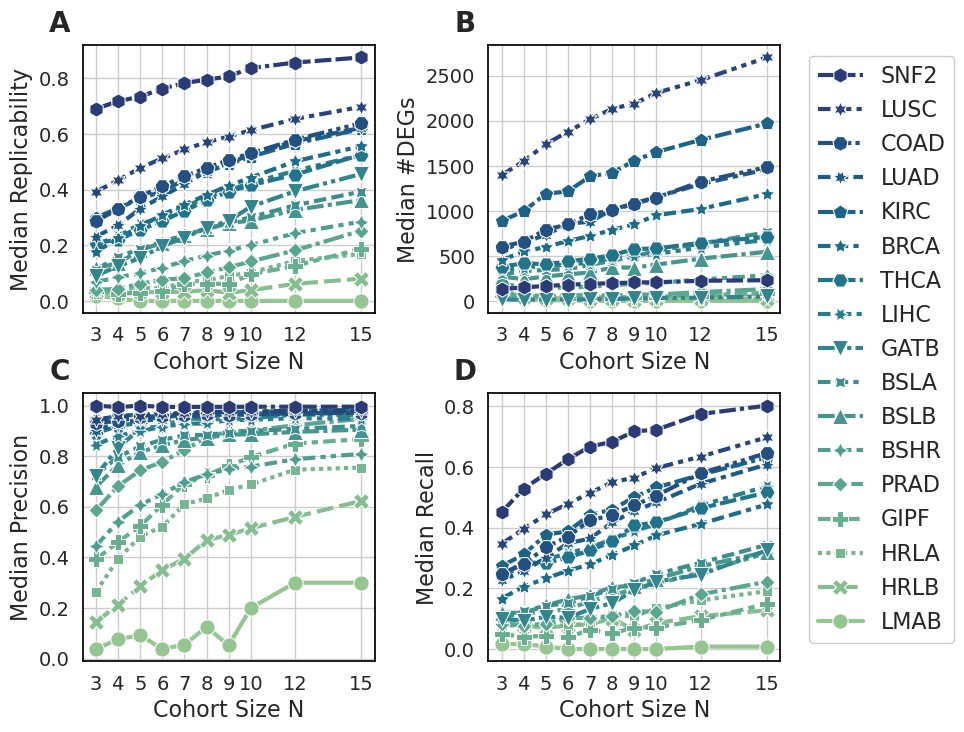

In [70]:
from matplotlib.ticker import MaxNLocator

sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

pretty_met = {"mcc": "MCC",
             "rec": "Recall",
             "rep": "Replicability",
             "prec": "Precision",
             "deg": "#DEGs",
             "terms": "#Terms"
             }

def make4x4fig(c, suffix, metrics):
    
    fig, axes = plt.subplots(2,len(metrics)//2, figsize=(4.5*len(metrics)//2,8), gridspec_kw={'hspace': 0.3,'wspace':0.39})
    axes = axes.flatten()
    
    all_N = sorted(set(c["N"]))
    c = c.sort_values(by=['Data'], key=lambda col: col.map({k: i for i, k in enumerate(order_rep)}))
    
    for i, (ax, met) in enumerate(zip(axes, metrics)):
    
        sns.lineplot(data=c, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=ax,lw=3,ms=11,palette=palette, hue_order=order_rep, style_order=order_rep)
                
        ax.legend([],[], frameon=False)
        ax.set_ylabel(f"Median {pretty_met[met]}")
        ax.set_xlabel("Cohort Size N")
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_ticks(all_N)
        ax.set(xticks=(all_N))
        ax.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(0.92,0.5),framealpha=1,title=None,ncol=1,markerscale=1)
    return fig

c = combined_all[~combined_all["isSynthetic"]]
c = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr) & (c["lfc_mode"] == lfc_mode) & (c["DEA"]==dea)]

fig = make4x4fig(c, suffix = "_method", metrics = ["rep","deg","prec","rec"])

figpath = f"../figures/fig2_metrics_vs_N.pdf"
#fig.tight_layout()
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

In [20]:
# At which N do we see >90% precision
cc=c[c["median_prec_method"]>0.95].sort_values(by="N")
cc[~cc["Data"].duplicated()]

cc=c[c["median_rec_method"]>0.5].sort_values(by="N")
cc[~cc["Data"].duplicated()]

,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_method,median_mcc,median_mcc0,...,median_prec0,median_prec0_method,median_prec_method,median_rec,median_rec_method,median_rep,median_rep_method,id,lfc_mode,isSynthetic
153,SNF2,4,None,DESeq2 Wald,0.05,1,154.5,154.5,0.714256,0.714256,...,0.993769,0.993769,0.993769,0.529412,0.529412,0.717514,0.717514,51,formal,False
162,LUSC,7,None,DESeq2 Wald,0.05,1,2015.5,2015.5,0.664101,0.664101,...,0.967768,0.968770,0.968770,0.515915,0.515216,0.543986,0.543986,54,formal,False
78,KIRC,9,None,DESeq2 Wald,0.05,1,1558.5,1558.5,0.665612,0.665612,...,0.974537,0.975027,0.975027,0.502811,0.501318,0.492099,0.492099,26,formal,False
51,COAD,10,None,DESeq2 Wald,0.05,1,1147.0,1147.0,0.672912,0.672912,...,0.966604,0.966795,0.966795,0.507286,0.506352,0.530041,0.530041,17,formal,False
144,LUAD,12,None,DESeq2 Wald,0.05,1,1299.0,1299.0,0.697637,0.697637,...,0.965541,0.966263,0.966263,0.548261,0.545101,0.573418,0.573418,48,formal,False
237,THCA,15,None,DESeq2 Wald,0.05,1,713.5,713.5,0.695832,0.695832,...,0.970758,0.971684,0.971684,0.517369,0.516593,0.525283,0.525283,79,formal,False
117,LIHC,15,None,DESeq2 Wald,0.05,1,681.0,681.0,0.694130,0.694130,...,0.940033,0.947971,0.947971,0.547804,0.536789,0.524436,0.524436,39,formal,False


# Figure 3: Enrichment

../figures/fig3_enrich_metrics_GO_Biological_Process_2023_vs_N.pdf


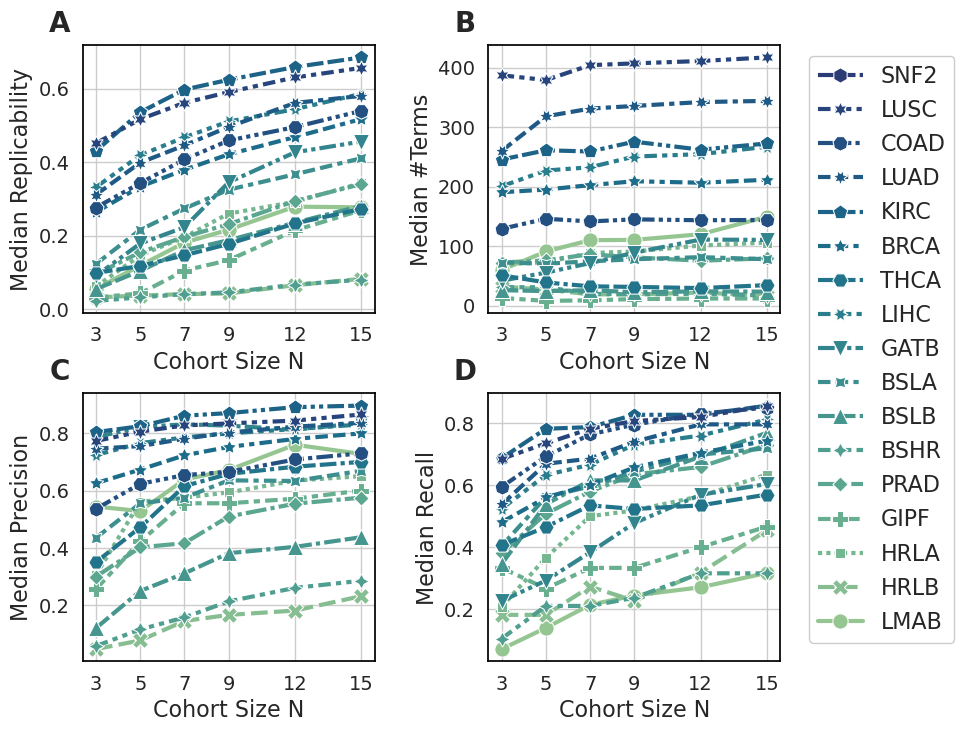

In [73]:
lib = "GO_Biological_Process_2023"
#lib = "KEGG_2021_Human"

dea = "DESeq2 Wald"
logFC = 1
lfc_mode = "formal"
fdr = 0.05

c = combined_gsea
c = c[(c["Out"]=="None") & (c["Library"]==lib)]

fig = make4x4fig(c, suffix = "", metrics = ["rep","terms","prec","rec"])

figpath = f"../figures/fig3_enrich_metrics_{lib}_vs_N.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Figure 5: Bootstrap

In [7]:
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import auc

df_boot = pd.read_csv("../data/multi/df_boot_long.csv", index_col=0)

In [8]:
all_N = [5,9,10]
ref = "Cohort"

dfm = pd.DataFrame(index = list(set(combined_all["Data"])))
for N_ in all_N:
    c = combined_all
    c = c[(c["N"]==N_)&(c["DEA"]=="DESeq2 Wald")&(c["logFC"]==1)&(c["lfc_mode"]=="formal")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{N_}"] = c["median_prec"]
    dfm[f"Rec_N{N_}"] = c["median_rec"]
    dfm[f"Rep_N{N_}"] = c["median_rep"]
    dfm[f"MCC_N{N_}"] = c["median_mcc"]

    c = combined_gsea
    c = c[(c["N"]==(9 if N_==10 else N_))&(c["Library"]=="GO_Biological_Process_2023")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{9 if N_==10 else N_}_GO"] = c["median_prec"]
    dfm[f"Rec_N{9 if N_==10 else N_}_GO"] = c["median_rec"]
    dfm[f"Rep_N{9 if N_==10 else N_}_GO"] = c["median_rep"]
    
    c = combined_gsea
    c = c[(c["N"]==(9 if N_==10 else N_))&(c["Library"]=="KEGG_2021_Human")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{9 if N_==10 else N_}_KEGG"] = c["median_prec"]
    dfm[f"Rec_N{9 if N_==10 else N_}_KEGG"] = c["median_rec"]
    dfm[f"Rep_N{9 if N_==10 else N_}_KEGG"] = c["median_rep"]

def aggregate(df_ref, metric, agg_func):
    return pd.DataFrame(df_ref.groupby(["Data","Cohort"])[metric].mean()).reset_index().groupby("Data")[metric].apply(lambda x: agg_func(x))
    
k = df_boot
for ref in ["Truth","Cohort"]:
    for N in all_N:
        df_ref = k[(k["Reference"]==ref) & (k["N"]==N)]

        # Crude
        # dfm[f"KL_{ref}_N{N}_mean"] = df_ref.groupby("Data")["KL"].mean()
        # dfm[f"KL_{ref}_N{N}_median"] = df_ref.groupby("Data")["KL"].median()
        # dfm[f"KL_{ref}_N{N}_std"] = df_ref.groupby("Data")["KL"].std()
        # dfm[f"Spear_{ref}_N{N}_mean"] = df_ref.groupby("Data")["Spearman"].mean()
        # dfm[f"Spear_{ref}_N{N}_median"] = df_ref.groupby("Data")["Spearman"].median()
        # dfm[f"Spear_{ref}_N{N}_std"] = df_ref.groupby("Data")["Spearman"].std()

        # Better
        dfm[f"KL_{ref}_N{N}_mean"] = aggregate(df_ref, "KL", np.mean)
        dfm[f"KL_{ref}_N{N}_median"] = aggregate(df_ref, "KL", np.median)
        dfm[f"KL_{ref}_N{N}_std"] = aggregate(df_ref, "KL", np.std)
        dfm[f"Spear_{ref}_N{N}_mean"] = aggregate(df_ref, "Spearman", np.mean)
        dfm[f"Spear_{ref}_N{N}_median"] = aggregate(df_ref, "Spearman", np.median)
        dfm[f"Spear_{ref}_N{N}_std"] = aggregate(df_ref, "Spearman", np.std)

Figsize (8.928, 13.64)
../figures/boot.vs.3metrics.rep.Spear..pdf


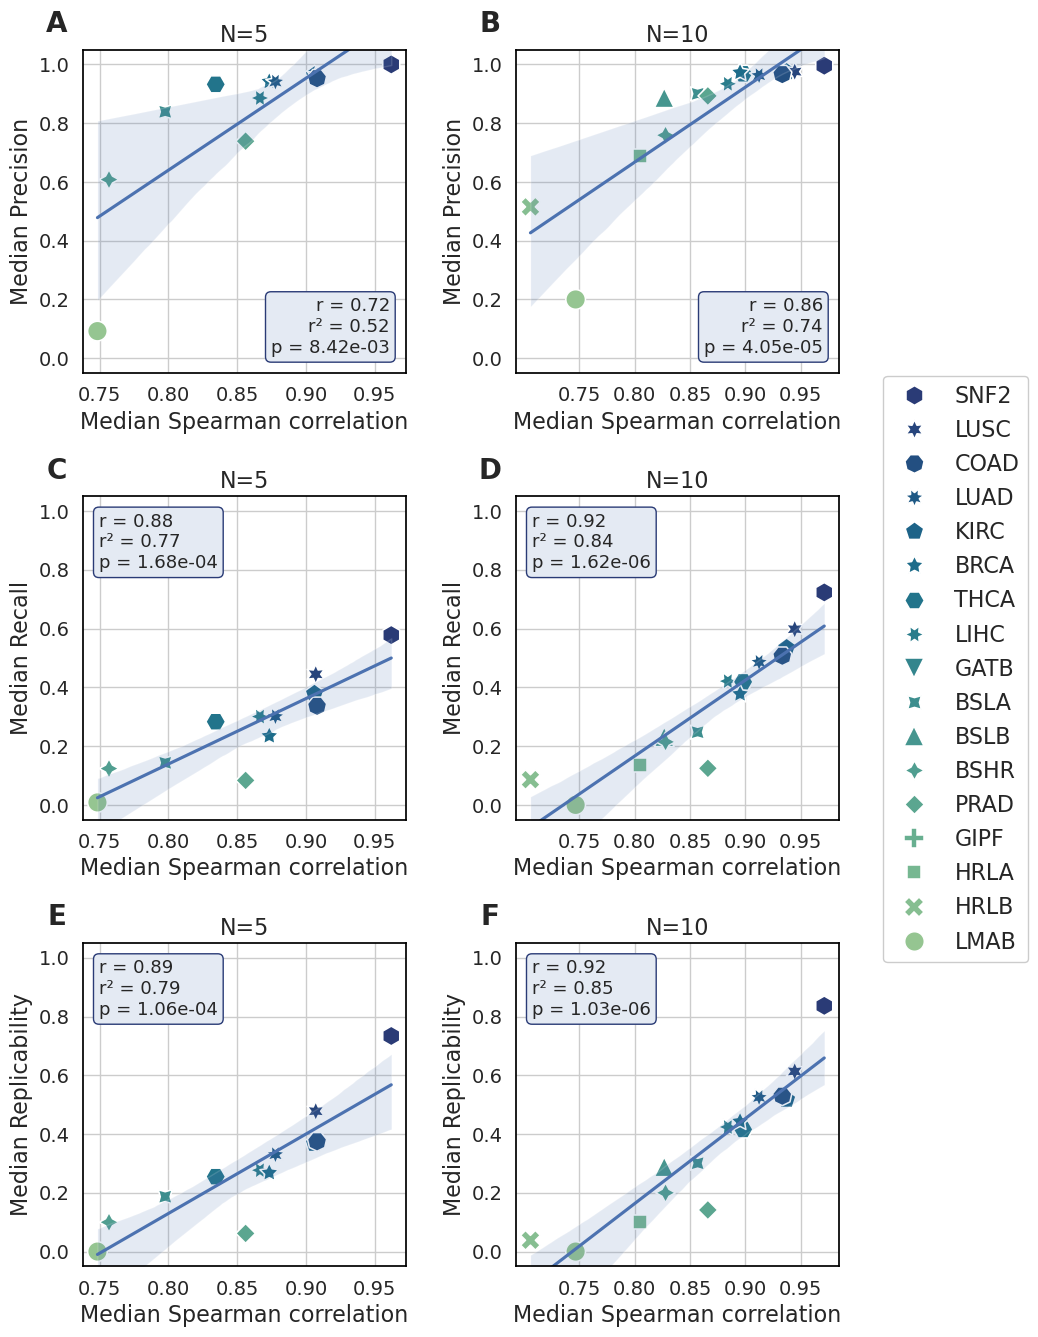

In [47]:
import scipy.stats as stats
pretty_met = {"Spear": "Spearman correlation", "KL":"KL Divergence","Rep":"Replicability","Prec":"Precision","Rec":"Recall"}

cohorts = range(50)
reference = "Cohort"
metric_suffix = f"median"
metric_prefix = "Spear" # KL, Spear

suffix = ""
#suffix = "_KEGG"
#suffix = "_GO"
y_prefix = "Rep"
# y_prefix = "Prec"
y_prefix = "Prec"

N_upper = 10 if suffix == "" else 9
boxprops = dict(boxstyle='round', facecolor='#e4eaf3', alpha=1, edgecolor="#2a3b76")

fit_prec = "linear"
#fit_prec = "binormal"

if metric_prefix == "KL": fit_prec = "linear"

y_prefixes = ["Prec", "Rec", "Rep"]

scale=1.24
figsize = (scale*7.2,scale*(-1+4*len(y_prefixes)))
print("Figsize",figsize)
fig, axes = plt.subplots(len(y_prefixes), 2, figsize=figsize,sharex=False,sharey=False)

for ax,  y_prefix in zip(axes, y_prefixes):
    ax = ax.flatten()

    sns.scatterplot(data=dfm, y=f"{y_prefix}_N5{suffix}", x=f"{metric_prefix}_{reference}_N5_{metric_suffix}", hue=dfm.index, style=dfm.index, hue_order=order_rep, style_order=order_rep, s=200, ax=ax[0], palette=palette)
    sns.scatterplot(data=dfm, y=f"{y_prefix}_N{N_upper}{suffix}", x=f"{metric_prefix}_{reference}_N10_{metric_suffix}", hue=dfm.index, hue_order=order_rep, style_order=order_rep, style=dfm.index, s=200, ax=ax[1], palette=palette)

    if fit_prec == "linear":
        sns.regplot(data=dfm, y=f"{y_prefix}_N5{suffix}", x=f"{metric_prefix}_{reference}_N5_{metric_suffix}", ax=ax[0], scatter_kws={'s':0}, order=1)
        sns.regplot(data=dfm, y=f"{y_prefix}_N{N_upper}{suffix}", x=f"{metric_prefix}_{reference}_N10_{metric_suffix}", scatter_kws={'s':0}, ax=ax[1], order=1)



    for N, a in zip([5,10], ax):
        x = dfm[f"{metric_prefix}_{reference}_N{N}_{metric_suffix}"].dropna()
        y = dfm[f"{y_prefix}_N{N_upper}{suffix}"].dropna()
        common = x.index.intersection(y.index)
        x, y = x.loc[common], y.loc[common]
    
        if fit_prec == "binormal":
            def binormal(x, a, b):
                return stats.norm.cdf(a * stats.norm.ppf(x) + b)
        
            p0 = [3,-2] # this is an mandatory initial guess
            params, pcov = curve_fit(binormal, x, y, p0=p0, bounds=(-2.9, np.inf))
            sigma_ab = np.sqrt(np.diagonal(pcov))
            print(params)
            xlin = np.linspace(0.7,1,100)
            y_binormal = binormal(xlin, *params)
            sns.lineplot(x=xlin, y=y_binormal, color="#4d72b0",lw=2,zorder=99,ax=a)
            bound_upper = binormal(xlin, *(params + sigma_ab))
            bound_lower = binormal(xlin, *(params - sigma_ab))
            a.fill_between(xlin, bound_lower, bound_upper,
                         color = '#e4eaf3', alpha = 1, zorder=0)
    
        else:
            r_val, p_val = stats.pearsonr(x,y)
            r2_val = r_val ** 2

            if y_prefix == "Prec":
                loc = (0.95, 0.05)
                ha = "right"
                va = "bottom"
            else:
                loc = (0.05,0.95)
                ha="left"
                va="top"
            a.text(loc[0], loc[1], f"r = {r_val:.2f}\nr² = {r2_val:.2f}\np = {p_val:.2e}", 
                   transform=a.transAxes, fontsize=13, va=va,ha=ha, bbox=boxprops)

        a.set(ylabel=f"Median {pretty_met[y_prefix]}")
    

### MISC.

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='center left', 
           bbox_to_anchor=(1,0.5),framealpha=1,title=None,ncol=1,markerscale=1)

for i, a in enumerate(axes.flatten()):
    a.legend().remove()
    a.set_box_aspect(1)
    a.set(xlabel=(f"{metric_suffix.split('_')[-1].capitalize()} {pretty_met[metric_prefix]}"))
    a.set(ylim=(-0.05,1.05))
    a.xaxis.set_ticks(np.arange(0.75, 1, 0.05))
    a.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    a.set_title("N=5" if i%2==0 else "N=10", size=16)
    
#fig.suptitle(f"25 Bootstrap trials | {len(cohorts)} Cohorts | {suffix}")
fig.tight_layout()
figpath = f"../figures/boot.vs.{len(y_prefixes)}metrics.{metric_prefix}.{suffix}.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Unused figures

/scratch/local/14598326/ipykernel_1239707/1106445559.py:43: UserWarning: 
The palette list has fewer values (10) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cc, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
/scratch/local/14598326/ipykernel_1239707/1106445559.py:43: UserWarning: 
The palette list has fewer values (10) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cc, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
/scratch/local/14598326/ipykernel_1239707/1106445559.py:43: UserWarning: 
The palette list has fewer values (10) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cc, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
/scratch/local/14598326/ipykernel_123

../figures/sfig2_deg_vs_N_data.pdf


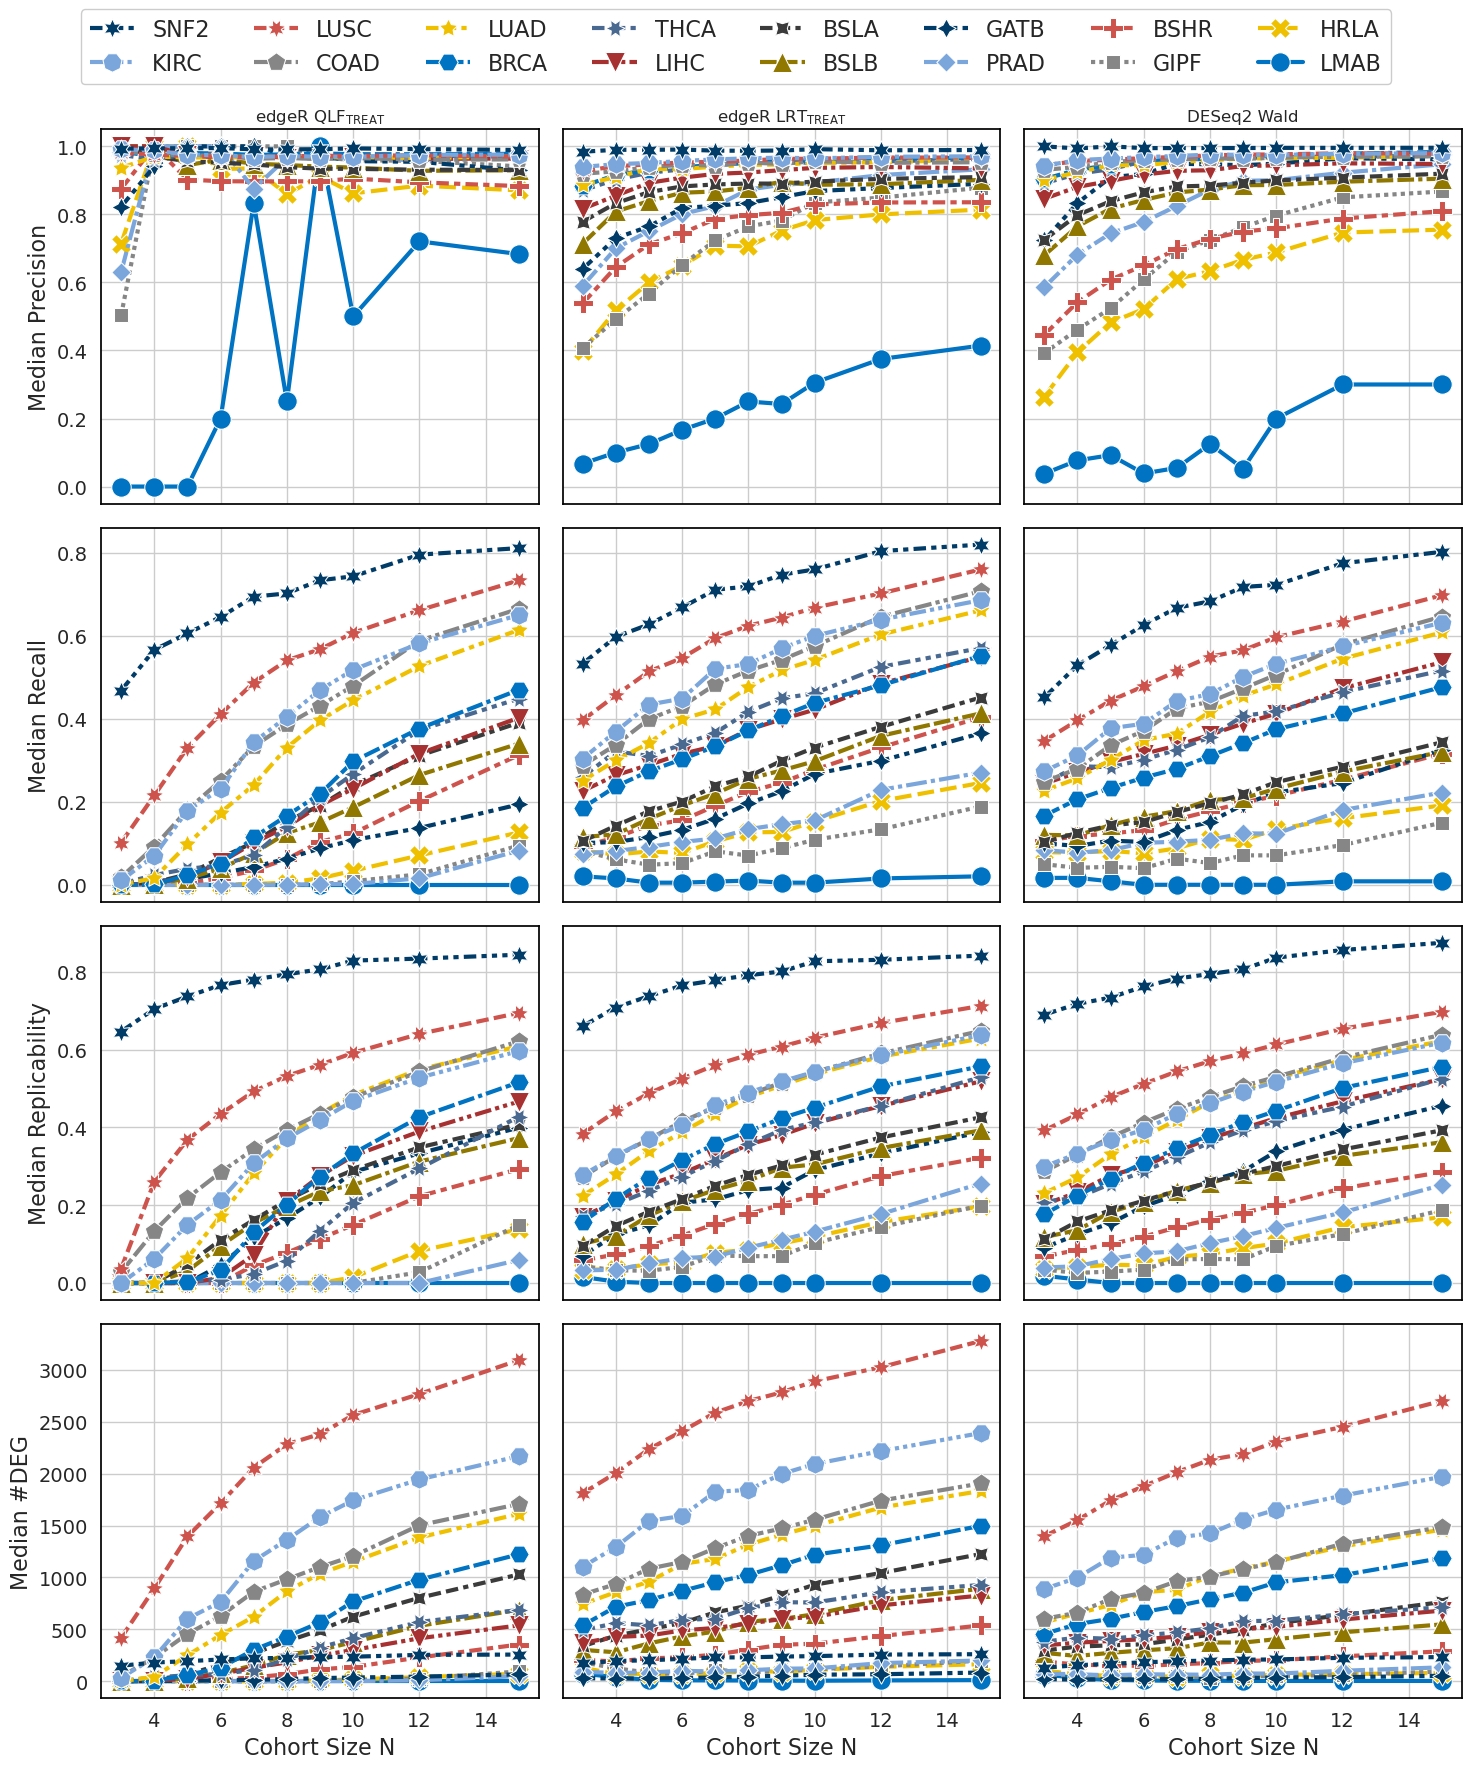

In [80]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

met = "rep"
met = "mcc"
met = "prec"
#met = "deg"
#met = "rec"

suffix = "_method"

fig, ax = plt.subplots(4,3, figsize=(15,17), sharex=True, sharey="row")

deas = ["edgeR QLF","edgeR LRT","DESeq2 Wald"]
logFC = "0"
fdr = 0.05

df = combined_all[~combined_all["isSynthetic"]]
df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal")]
df = df[(df["FDR"]==0.05) & (df["Out"]=="None")]

#order_rep = np.array(["LUSC","COAD","KIRC","LUAD","BRCA","THCA","LIHC","PRAD"])
#order_rep = set(combined_all["Data"])
order_rep = df[(df["DEA"]=="edgeR LRT")&(df["N"]==3)].sort_values(by="median_prec_method")["Data"].values
def kf(x):
    print(order_rep,x)
    return np.where(order_rep==x)[0][0]

palette = jco[:len(order_rep)]

for j, dea in enumerate(deas):
    dea_print = rf"{dea}$_\mathrm{{TREAT}}$" if dea != "DESeq2 Wald" else dea
    ax[0][j].set_title(dea_print)
    
    for i, met in enumerate(["prec","rec","rep","deg"]):
        
        a = ax[i][j]
        c = df
        c = c.sort_values(by=['Data'], key=lambda col: col.map({k: i for i, k in enumerate(order_rep)}))
        cc = c[c["DEA"]==dea]
        if len(cc) < 1: 
            continue
    
        sns.lineplot(data=cc, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
                
        prettymet = "MCC" if met.startswith("mcc") else ("Recall" if met == "rec" else ("Precision" if met.startswith("prec") else ("#DEG" if met == "deg" else "Replicability")))
        a.set_ylabel(f"Median {prettymet}")
        a.legend([],[], frameon=False)
        
handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc="upper center", ncol=8, bbox_to_anchor=(0.5, 1.05),markerscale=1,framealpha=1)

for a in ax[-1]: a.set_xlabel("Cohort Size N")

prefix = "sfig2" if met == "deg" else "sfig3" if met == "rep" else "sfig4" if met.startswith("mcc") else "sfig5" if met == "rec" else "sfig6"
figpath = f"../figures/{prefix}_{met}_vs_N_data.pdf"
fig.tight_layout()
#fig.savefig(figpath)
print(figpath)

/scratch/local/14628014/ipykernel_2124282/3101021982.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=df, x="median_rec", y="median_prec", hue="N", style="Data", ax=ax, palette=npg,s=200)


[(-0.05, 1.05), (-0.05, 1.05)]

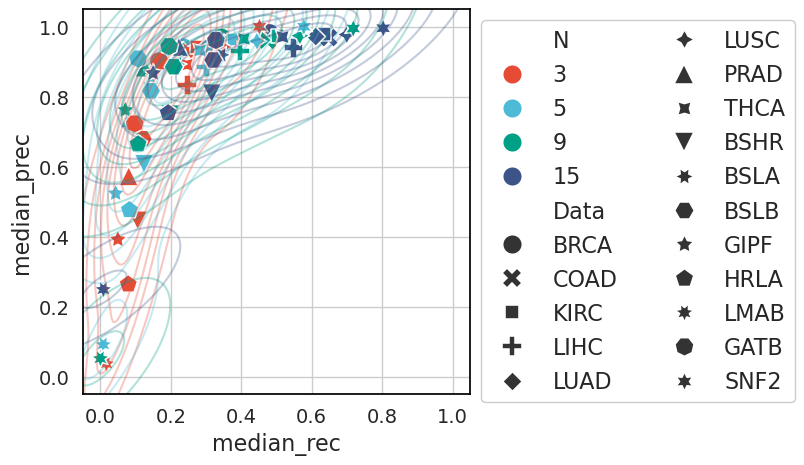

In [6]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

method = "DESeq2 Wald"
all_N_sub = [3,5,9,15]

fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

df = combined_all[~combined_all["isSynthetic"]]

df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal") & (df["DEA"]==method)]
df = df[(df["N"]).isin(all_N_sub)]
sns.scatterplot(data=df, x="median_rec", y="median_prec", hue="N", style="Data", ax=ax, palette=npg,s=200)

for i, N in enumerate(all_N_sub):
    sns.kdeplot(data=df[df["N"]==N], x="median_rec", y="median_prec",color=npg[i],alpha=0.3)

ax.legend(framealpha=1,title=None,ncol=2,markerscale=1,bbox_to_anchor=(1,1))
ax.set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))

/scratch/local/14628014/ipykernel_2124282/3519393650.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_N, x="median_rec_method", y="median_prec_method", color=npg[i], style="Data", ax=ax[i], palette=npg,s=200)
/scratch/local/14628014/ipykernel_2124282/3519393650.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_N, x="median_rec_method", y="median_prec_method", color=npg[i], style="Data", ax=ax[i], palette=npg,s=200)
/scratch/local/14628014/ipykernel_2124282/3519393650.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_N, x="median_rec_method", y="median_prec_method", color=npg[i], style="Data", ax=ax[i], palette=npg,s=200)
/scratch/local/14628014/ipykernel_2124282/3519393650.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_N, x="median_rec_method", y

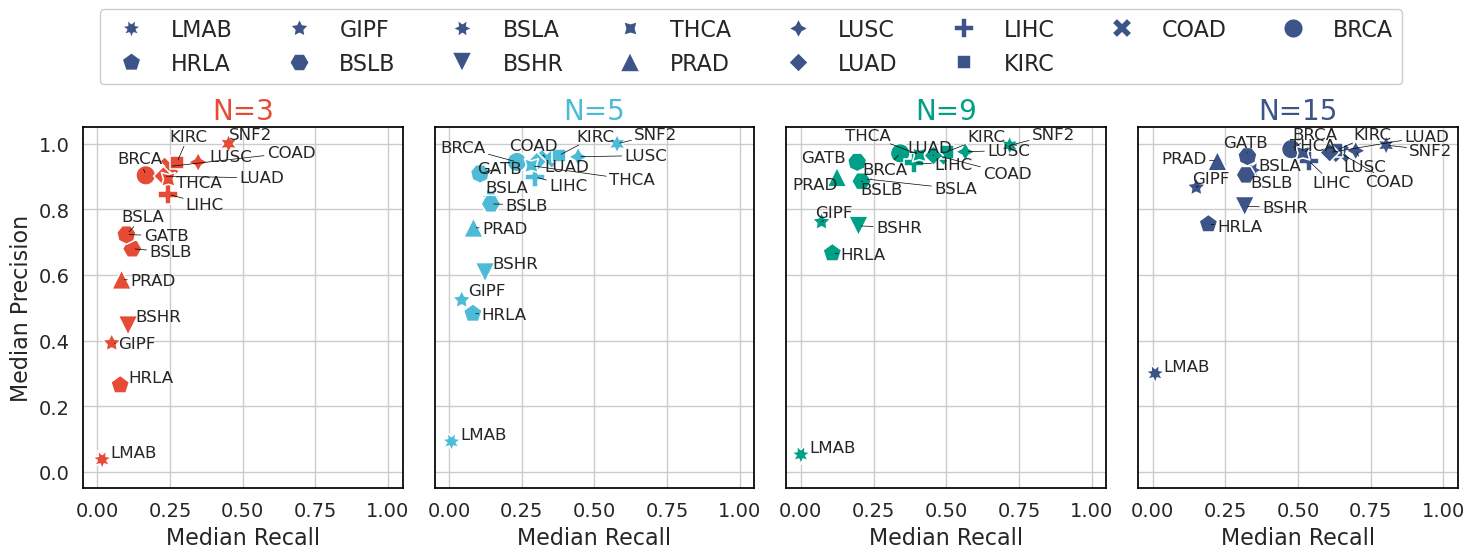

In [41]:
from adjustText import adjust_text

sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

method = "DESeq2 Wald"
all_N_sub = [3,5,9,15]

fig, ax = plt.subplots(1,4, figsize=(15,5), sharey=True, sharex=True)

df = combined_all[~combined_all["isSynthetic"]]

df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal") & (df["DEA"]==method)]

for i, N in enumerate(all_N_sub):
    df_N = df[df["N"]==N]
    sns.scatterplot(data=df_N, x="median_rec_method", y="median_prec_method", color=npg[i], style="Data", ax=ax[i], palette=npg,s=200)
    #sns.kdeplot(data=df_N, x="median_rec_method", y="median_prec_method",color=npg[i],alpha=0.3,ax=ax[i])

    ax[i].set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))
    ax[i].legend([],[], frameon=False)
    ax[i].set_title(f"N={N}",color=npg[i], fontsize=20)
    ax[i].set(xlabel="Median Recall", ylabel="Median Precision")

    texts = []
    for x, y, s in zip(df_N["median_rec_method"], df_N["median_prec_method"], df_N["Data"]):
      texts.append(ax[i].text(x, y, s, size=12))    
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
    
handles, labels = ax[-1].get_legend_handles_labels()
handles, labels = handles[:-2], labels[:-2]
fig.legend(handles[::-1], labels[::-1], loc="upper center", ncol=8, bbox_to_anchor=(0.51, 1.15),markerscale=1,framealpha=1)
fig.tight_layout()

In [110]:
df

,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_method,median_mcc,median_mcc0,...,median_prec0_method,median_prec_method,median_rec,median_rec_method,median_rep,median_rep_method,id,rnd_rep,lfc_mode,isSynthetic
0,BRCA,3,None,DESeq2 Wald,0.05,1,456.5,456.5,0.358841,0.358841,...,0.903758,0.903758,0.167151,0.166667,0.176676,0.176676,0,0.012977,formal,False
3,BRCA,4,None,DESeq2 Wald,0.05,1,551.0,551.0,0.402181,0.402181,...,0.931427,0.931427,0.207798,0.206076,0.224355,0.224355,1,0.015705,formal,False
6,BRCA,5,None,DESeq2 Wald,0.05,1,601.5,601.5,0.440800,0.440800,...,0.944489,0.944489,0.234550,0.233374,0.268174,0.268174,2,0.017169,formal,False
9,BRCA,6,None,DESeq2 Wald,0.05,1,667.5,667.5,0.456607,0.456607,...,0.954270,0.954270,0.260473,0.258415,0.309300,0.309300,3,0.019089,formal,False
12,BRCA,7,None,DESeq2 Wald,0.05,1,724.0,724.0,0.485922,0.485922,...,0.961556,0.961556,0.281418,0.279557,0.345806,0.345806,4,0.020738,formal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,SNF2,8,None,DESeq2 Wald,0.05,1,199.0,199.0,0.815090,0.815090,...,0.994987,0.994987,0.683391,0.683391,0.794457,0.794457,55,NaN,formal,False
168,SNF2,9,None,DESeq2 Wald,0.05,1,207.5,207.5,0.829731,0.829731,...,0.995074,0.995074,0.717993,0.717993,0.806306,0.806306,56,NaN,formal,False
171,SNF2,10,None,DESeq2 Wald,0.05,1,210.0,210.0,0.844448,0.844448,...,0.995516,0.995516,0.723183,0.723183,0.836283,0.836283,57,NaN,formal,False
174,SNF2,12,None,DESeq2 Wald,0.05,1,226.0,226.0,0.872343,0.872343,...,0.995546,0.995546,0.775087,0.775087,0.856000,0.856000,58,NaN,formal,False


/scratch/local/14628014/ipykernel_2124282/3099839817.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="median_rec", y="median_prec", color="grey", style="Data", palette=npg,s=200,alpha=0.5,ax=ax)
/scratch/local/14628014/ipykernel_2124282/3099839817.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="median_rec", y="median_prec", color="grey", style="Data", palette=npg,s=200,alpha=0.5,ax=ax)
/scratch/local/14628014/ipykernel_2124282/3099839817.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="median_rec", y="median_prec", color="grey", style="Data", palette=npg,s=200,alpha=0.5,ax=ax)


DESeq2 Wald [1.32984541 2.228885  ]
edgeR QLF [0.12617117 1.5958638 ]
edgeR LRT [1.07814792 1.47489305]


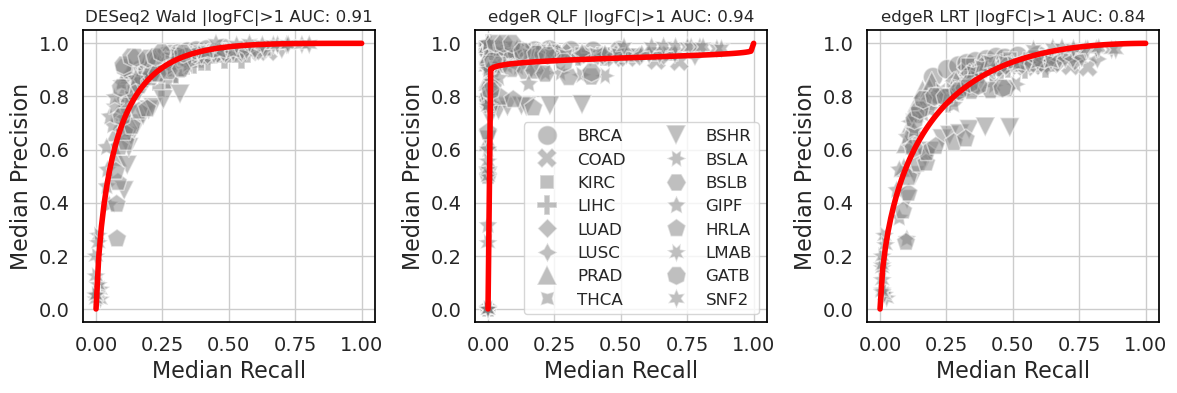

In [134]:
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import auc

scale=0.6
fig,ax=plt.subplots(1,3,figsize=(scale*20,scale*10))
axes=ax.flatten()

df_a = combined_all[~combined_all["isSynthetic"]]
df_a = df_a[(df_a["logFC"]==1) & (df_a["lfc_mode"]=="formal")]

methods = ["DESeq2 Wald","edgeR QLF","edgeR LRT"]
for ax, method in zip(axes, methods):

    df = df_a[df_a["DEA"]==method]
    sns.scatterplot(data=df, x="median_rec", y="median_prec", color="grey", style="Data", palette=npg,s=200,alpha=0.5,ax=ax)
    ax.set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))
    x = np.linspace(0,1,100)
    

    def binormal(x, a, b):
        return stats.norm.cdf(a * stats.norm.ppf(x) + b)
    
    params, _ = curve_fit(binormal, df['median_rec'], df['median_prec'], bounds=(0, np.inf))
    y_binormal = binormal(x, *params)
    sns.lineplot(x=x, y=y_binormal, color="red",lw=4,zorder=99,ax=ax)
    
    # params_data = [[]]
    # for data in set(df["Data"]):
    #     if data in ["LMAB","SNF2"]: continue
    #     df_d = df[df["Data"]==data]
    #     params_d, _ = curve_fit(binormal, df_d['median_rec'], df_d['median_prec'])
    #     params_data.append(params_d)
    #     y_binormal = binormal(x, *params_d)
    #     sns.lineplot(x=x, y=y_binormal,alpha=0.25,color="grey",ax=ax)
    print(method,params)
    ax.set(xlabel="Median Recall", ylabel="Median Precision")
    ax.set_aspect(1)
    auc_value = auc(x,y_binormal)
    ax.set_title(f"{method} |logFC|>1 AUC: {auc_value:.2f}")
    ax.legend([],[], frameon=False)

axes[1].legend(loc="lower right",ncol=2,prop={'size': 12})
#handles, labels = axes[-1].get_legend_handles_labels()
#fig.legend(handles[::-1], labels[::-1], loc="upper center", ncol=8, bbox_to_anchor=(0.51, 1),markerscale=1,framealpha=1)
fig.tight_layout()